In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.models.kernels import RBF
from mfpml.problems.multifidelity_functions import Forrester_1b
from mfpml.models.gaussian_process import GaussianProcess
from mfpml.optimization.evolutionary_algorithms import DE
from scipy.linalg import cholesky, solve
from scipy.optimize import minimize
from mfbml.methods.mfrbfgp import MFRBFGPR

# import accuracy measures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# define function
func = Forrester_1b()

# define sampler
sampler = MFSobolSequence(design_space=func.design_space, seed=1)
sample_x = sampler.get_samples(num_hf_samples=20, num_lf_samples=200)
# update sample_x['hf']
# sample_x['hf'] = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
sample_y = {}
# get response
sample_y["hf"] = func.hf(sample_x["hf"]) + np.random.normal(
    0, 0.3, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, 0.3, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noisy = func.hf(test_x_noisy) + np.random.normal(
    0, 0.3, size=test_x_noisy.shape[0]
).reshape(-1, 1)

# use DE for optimization
# optimizer = DE(num_gen=500, num_pop=100)

In [3]:
def calculate_log_marginal_likelihood_mf(model: MFRBFGPR, sample_x, sample_y):
    # get test data
    sample_scaled = model.normalize_input(sample_x)
    num_sample = sample_x.shape[0]
    f = model.predict_lf(sample_x)
    # get the kernel matrix
    K = model.kernel.get_kernel_matrix(
        sample_scaled, sample_scaled
    ) + model.noise**2 * np.eye(num_sample)

    L = cholesky(K, lower=True)

    # step 1: get the optimal beta
    # f, basis function
    # self.f = self.predict_lf(self.sample_xh)
    # alpha = K^(-1) * Y
    alpha = solve(L.T, solve(L, sample_y))
    # K^(-1)f
    KF = solve(L.T, solve(L, f))
    ld = cholesky(np.dot(f.T, KF), lower=True)
    # beta = (F^T *K^(-1)* F)^(-1) * F^T *R^(-1) * Y
    beta = solve(ld.T, solve(ld, np.dot(f.T, alpha)))

    # step 2: get the optimal sigma2
    gamma = solve(L.T, solve(L, (sample_y - np.dot(f, beta))))
    sigma2 = np.dot((sample_y - np.dot(f, model.beta)).T, gamma) / num_sample

    # step 3: get the optimal log likelihood
    logp = (-0.5 * num_sample * sigma2 - np.sum(np.log(np.diag(L)))).item()

    return logp

In [4]:
def calculate_log_marginal_likelihood_gpr(model: GaussianProcess, sample_x, sample_y):
    # get test data
    sample_scaled = model.normalize_input(sample_x, bounds=model.bounds)
    num_sample = sample_x.shape[0]
    f = model.regr(sample_x)
    # get the kernel matrix
    K = model.kernel.get_kernel_matrix(
        sample_scaled, sample_scaled
    ) + model.noise**2 * np.eye(num_sample)

    L = cholesky(K, lower=True)

    # step 1: get the optimal beta
    # f, basis function
    # self.f = self.predict_lf(self.sample_xh)
    # alpha = K^(-1) * Y
    alpha = solve(L.T, solve(L, sample_y))
    # K^(-1)f
    KF = solve(L.T, solve(L, f))
    ld = cholesky(np.dot(f.T, KF), lower=True)
    # beta = (F^T *K^(-1)* F)^(-1) * F^T *R^(-1) * Y
    beta = solve(ld.T, solve(ld, np.dot(f.T, alpha)))

    # step 2: get the optimal sigma2
    gamma = solve(L.T, solve(L, (sample_y - np.dot(f, beta))))
    sigma2 = np.dot((sample_y - np.dot(f, model.beta)).T, gamma) / num_sample

    # step 3: get the optimal log likelihood
    logp = (-0.5 * num_sample * sigma2 - np.sum(np.log(np.diag(L)))).item()

    return logp

In [5]:
# define kernel
start_time = time.time()
mfrbfgp = MFRBFGPR(design_space=func.input_domain, noise_prior=0.3)
mfrbfgp.train(samples=sample_x, responses=sample_y)
mfrbfgp_pred_y, mfrbfgp_pred_std = mfrbfgp.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly = mfrbfgp.predict_lf(test_xl=test_x)
end_time = time.time()
cpu_time = end_time - start_time

In [6]:
# calculate accuracy
mse = mean_squared_error(test_hy, mfrbfgp_pred_y)
mae = mean_absolute_error(test_hy, mfrbfgp_pred_y)
r2 = r2_score(test_hy, mfrbfgp_pred_y)

# calculate log likelihood for test_x_noisy
log_likelihood = calculate_log_marginal_likelihood_mf(
    mfrbfgp, test_x_noisy, test_hy_noisy
)

# print accuracy
print("mse: ", mse)
print("mae: ", mae)
print("r2: ", r2)
print("log_likelihood: ", log_likelihood)
print("cpu_time: ", cpu_time)

mse:  0.07439696767161354
mae:  0.19660713077326464
r2:  0.9962725812866815
log_likelihood:  614.4545003129537
cpu_time:  0.13036227226257324


In [7]:
print(mfrbfgp.beta)
print(mfrbfgp.kernel.param)
print(mfrbfgp.noise)
print(mfrbfgp.logp)

[[0.55214156]]
[62.97505818]
0.3
-103.31135842606926


In [8]:
# add gaussian process regression model for comparison
start_time = time.time()
gpr = GaussianProcess(func.input_domain, noise_prior=0.3)
gpr.train(sample_x["hf"], sample_y["hf"])
gpr_pred_y, gpr_pred_std = gpr.predict(test_x, return_std=True)
end_time = time.time()
cpu_time = end_time - start_time

In [9]:
# calculate accuracy
mse = mean_squared_error(test_hy, gpr_pred_y)
mae = mean_absolute_error(test_hy, gpr_pred_y)
r2 = r2_score(test_hy, gpr_pred_y)
# calculate log likelihood for test_x_noisy
log_likelihood = calculate_log_marginal_likelihood_gpr(
    gpr, test_x_noisy, test_hy_noisy)


# print accuracy
print("mse: ", mse)
print("mae: ", mae)
print("r2: ", r2)
print("log_likelihood: ", log_likelihood)
print("cpu_time: ", cpu_time)

mse:  0.10725685133590195
mae:  0.23485875502767714
r2:  0.9946262434167246
log_likelihood:  585.5192476844566
cpu_time:  0.27294087409973145


In [10]:
print(gpr.kernel.param)
print(gpr.kernel._get_bounds)
print(gpr.logp)
print(gpr.noise)

[84.7797028]
[[-4  3]]
-128.98604787643262
0.3


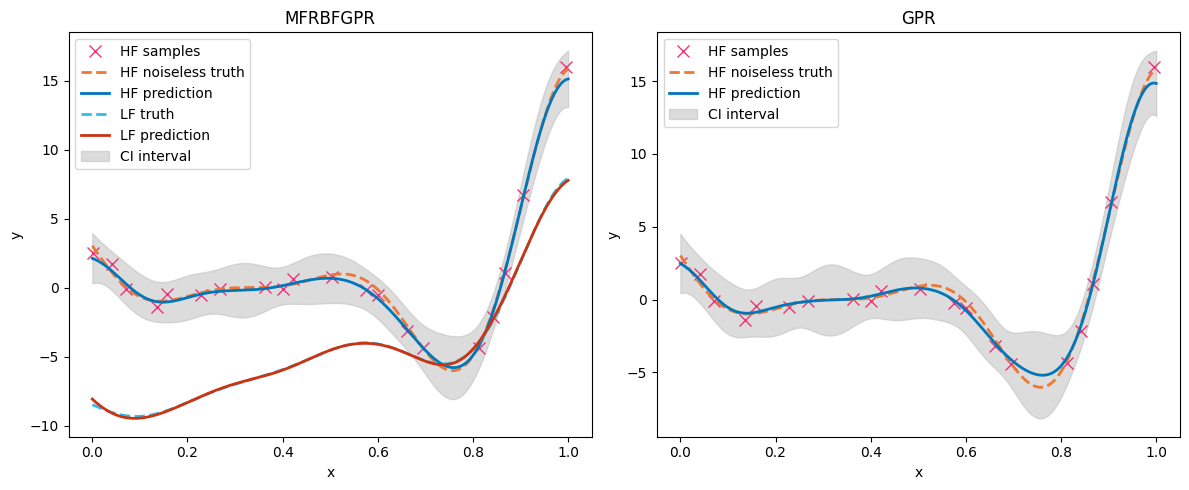

In [11]:
# plot results of mfrbfgp and gpr in one figure
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[0].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[0].plot(
    test_x, mfrbfgp_pred_y, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[0].plot(test_x, test_ly, "--", color="#33BBEE",
           linewidth=2, label="LF truth")
ax[0].plot(test_x, pred_ly, "-", color="#CC3311",
           linewidth=2, label="LF prediction")
# ax[0].plot(sample_x["lf"], sample_y["lf"], "x", label="lf samples")
ax[0].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y - 2 * mfrbfgp_pred_std).flatten(),
    (mfrbfgp_pred_y + 2 * mfrbfgp_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].legend()
ax[0].set_title("MFRBFGPR")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
# for gpr
ax[1].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[1].plot(test_x, gpr_pred_y, "-", color="#0077BB",
           linewidth=2, label="HF prediction")
ax[1].fill_between(
    test_x.flatten(),
    (gpr_pred_y - 2 * gpr_pred_std).flatten(),
    (gpr_pred_y + 2 * gpr_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1].legend()
ax[1].set_title("GPR")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
plt.tight_layout()
plt.savefig("mf_rbf_gpr_noisy_1d.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
# the case of unknown noise level